## Deep Graph Library (DGL)

In [30]:
import numpy as np
import dgl

In [31]:
num = input("Enter number of sets needed: ")
num = int(num)

Enter number of sets needed: 2


In [32]:
def build_karate_club_graph():
    
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
            5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
            24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
            29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
            31, 32])

    addition = lambda x:x+35

    for ix in range(num-1):
        new_src = addition(src)
        new_dst = addition(dst)
        src = np.concatenate([src,new_src])
        dst = np.concatenate([dst,new_dst])

    #print(src)
    
    u = np.concatenate([src,dst])
    v = np.concatenate([dst,src])

    return dgl.DGLGraph((u,v))

In [33]:
G = build_karate_club_graph()
print(G.number_of_nodes())
print(G.number_of_edges())

69
312


In [34]:
import networkx as nx

In [35]:
nx_G = G.to_networkx().to_undirected() #Converting G to networkx graph to visualise 

In [36]:
nx_G

In [37]:
#nx.draw?

In [38]:
pos1 = nx.kamada_kawai_layout(nx_G)

In [39]:
pos1 #Positions of nodes -> Dictionary

{0: array([0.34224246, 0.15651729]),
 1: array([0.2759002 , 0.34540017]),
 2: array([-0.001734  ,  0.14535331]),
 3: array([0.2336368 , 0.04242552]),
 4: array([ 0.54708125, -0.183217  ]),
 5: array([ 0.69276006, -0.00871927]),
 6: array([0.68245774, 0.13773154]),
 7: array([ 0.20094529, -0.083453  ]),
 8: array([-0.0026989,  0.3436933]),
 9: array([-0.15208288,  0.54451383]),
 10: array([ 0.54163807, -0.04414024]),
 11: array([0.65557455, 0.34768371]),
 12: array([ 0.36644337, -0.25097295]),
 13: array([0.07967944, 0.27611075]),
 14: array([-0.33560139,  0.69066872]),
 15: array([-0.44561421,  0.63963143]),
 16: array([ 1.        , -0.00386706]),
 17: array([0.47024892, 0.54702604]),
 18: array([-0.54049075,  0.56266396]),
 19: array([0.10049335, 0.45980483]),
 20: array([-0.61215431,  0.45721377]),
 21: array([0.54358893, 0.44933398]),
 22: array([-0.62078104,  0.31272599]),
 23: array([-0.48039989, -0.05133177]),
 24: array([-0.29785673, -0.34751563]),
 25: array([-0.16284437, -0.35

C:\Users\Varun Sirpal\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


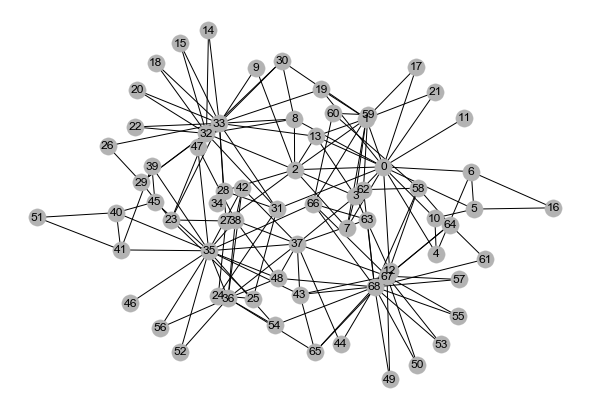

In [40]:
#Undirected graph using networkx
import matplotlib.pyplot as plt
plt.style.use("seaborn")
nx.draw(nx_G,pos1,with_labels=True,node_color=[[0.7,0.7,0.7]])

## Assigning node features

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
embed = nn.Embedding(G.number_of_nodes(),6)

In [43]:
G.ndata['feat'] = embed.weight

In [44]:
print(G.ndata['feat'][[2,7]])

tensor([[-1.0992,  0.0629, -1.6479, -0.2495,  1.2940,  2.0804],
        [ 0.8896,  0.1167, -0.6661, -0.9577,  0.3005, -0.5256]],
       grad_fn=<IndexBackward>)


## Define Graph Convolutional Network

In [45]:
from dgl.nn.pytorch import GraphConv

In [46]:
class GCN(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(GCN,self).__init__()
        self.conv1 = GraphConv(input_size,hidden_size)
        self.conv2 = GraphConv(hidden_size,num_classes)
#         self.conv3 = GraphConv(hidden_size2,num_classes)
    
    def forward(self,G,inputs):
        h = self.conv1(G,inputs)
        h = torch.relu(h)  #ReLU Activation
        h = self.conv2(G,h)
        return h

In [47]:
#2 output classes to represent cluster of instructor(node 0) and 
#club president(node 34) of Karate Club
net = GCN(6,5,4)

In [48]:
inputs = embed.weight
labelled_nodes = torch.tensor([0,33,35,68])
labels = torch.tensor([0,1,2,3])

## Training

In [49]:
net

GCN(
  (conv1): GraphConv(in=6, out=5, normalization=both, activation=None)
  (conv2): GraphConv(in=5, out=4, normalization=both, activation=None)
)

In [50]:
net(G,inputs).detach()

tensor([[ 5.5082e-01,  3.3637e-02,  3.7553e-01,  3.5257e-01],
        [ 2.4387e-01,  3.2113e-02,  1.5369e-01,  1.5113e-01],
        [ 4.2198e-01,  4.9283e-02,  2.1766e-01,  2.5422e-01],
        [ 8.0483e-02,  1.0454e-02,  1.2985e-01,  6.1816e-02],
        [ 1.4851e-01,  1.1948e-02,  2.0884e-01,  1.4190e-01],
        [ 3.3730e-01,  2.2637e-02,  3.5400e-01,  2.8107e-01],
        [ 9.6362e-01,  1.5829e-01,  4.9790e-01,  6.2737e-01],
        [ 2.3150e-01,  4.1405e-02,  2.6187e-01,  1.9535e-01],
        [ 2.7492e-01,  7.5554e-02,  2.9091e-01,  2.2601e-01],
        [ 9.1864e-02,  6.0308e-02,  1.6440e-01,  9.9091e-02],
        [ 8.7171e-01,  1.6858e-01,  3.7500e-01,  5.4177e-01],
        [ 2.6430e-01,  3.6548e-02,  3.0720e-01,  2.3965e-01],
        [ 3.5778e-01,  7.7927e-02,  3.1717e-01,  2.9605e-01],
        [ 3.0106e-01,  6.3100e-02,  3.3796e-01,  2.5861e-01],
        [ 3.1548e-01,  6.9959e-02,  2.7958e-01,  2.4570e-01],
        [ 3.1548e-01,  6.9959e-02,  2.7958e-01,  2.4570e-01],
        

In [58]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(100):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labelled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch {} | Loss: {}'.format(epoch + 1, loss.item()))

Epoch 1 | Loss: 0.01752970926463604
Epoch 2 | Loss: 0.014811759814620018
Epoch 3 | Loss: 0.012567649595439434
Epoch 4 | Loss: 0.010685771703720093
Epoch 5 | Loss: 0.009091878309845924
Epoch 6 | Loss: 0.007737227715551853
Epoch 7 | Loss: 0.006584865041077137
Epoch 8 | Loss: 0.005605608224868774
Epoch 9 | Loss: 0.004775550216436386
Epoch 10 | Loss: 0.004080488346517086
Epoch 11 | Loss: 0.003492876887321472
Epoch 12 | Loss: 0.002997391391545534
Epoch 13 | Loss: 0.0025795947294682264
Epoch 14 | Loss: 0.002227353397756815
Epoch 15 | Loss: 0.0019305977039039135
Epoch 16 | Loss: 0.0016805408522486687
Epoch 17 | Loss: 0.0014693951234221458
Epoch 18 | Loss: 0.0012906237971037626
Epoch 19 | Loss: 0.0011389476712793112
Epoch 20 | Loss: 0.0010099068749696016
Epoch 21 | Loss: 0.0008996256510727108
Epoch 22 | Loss: 0.0008052333723753691
Epoch 23 | Loss: 0.0007240923587232828
Epoch 24 | Loss: 0.0006542460760101676
Epoch 25 | Loss: 0.00059394387062639
Epoch 26 | Loss: 0.0005415223422460258
Epoch 27 | 

In [59]:
def violators(epoch):
        i = epoch
        pos = {}
        nodes_per_set = 34
        print("Violators at epoch: ", epoch)
        violator_cnt = 0
        for v in range(G.number_of_nodes()):
            pos[v] = all_logits[i][v].numpy()  # i = no. of epoch, v = no. of node
            cluster = pos[v].argmax()
            for set_idx in range(num): #num is number of sets defined earlier
                if v>= nodes_per_set*set_idx and v < nodes_per_set*(set_idx+1):
                    if cluster < set_idx*2 or cluster > set_idx*2+1:
                        print("Node ", v, " Cluster :", cluster)
                        violator_cnt+=1

        print("Total Violators = ", violator_cnt)
        
violators(99)

Violators at epoch:  99
Node  51  Cluster : 0
Total Violators =  1


In [60]:
logp[labelled_nodes]

tensor([[-2.1457e-05, -1.3415e+01, -1.0826e+01, -2.1733e+01],
        [-1.0839e+01, -2.3842e-05, -1.5821e+01, -1.2429e+01],
        [-1.1266e+01, -2.3786e+01, -4.8159e-05, -1.0250e+01],
        [-2.2833e+01, -1.1789e+01, -8.7333e+00, -1.6879e-04]],
       grad_fn=<IndexBackward>)

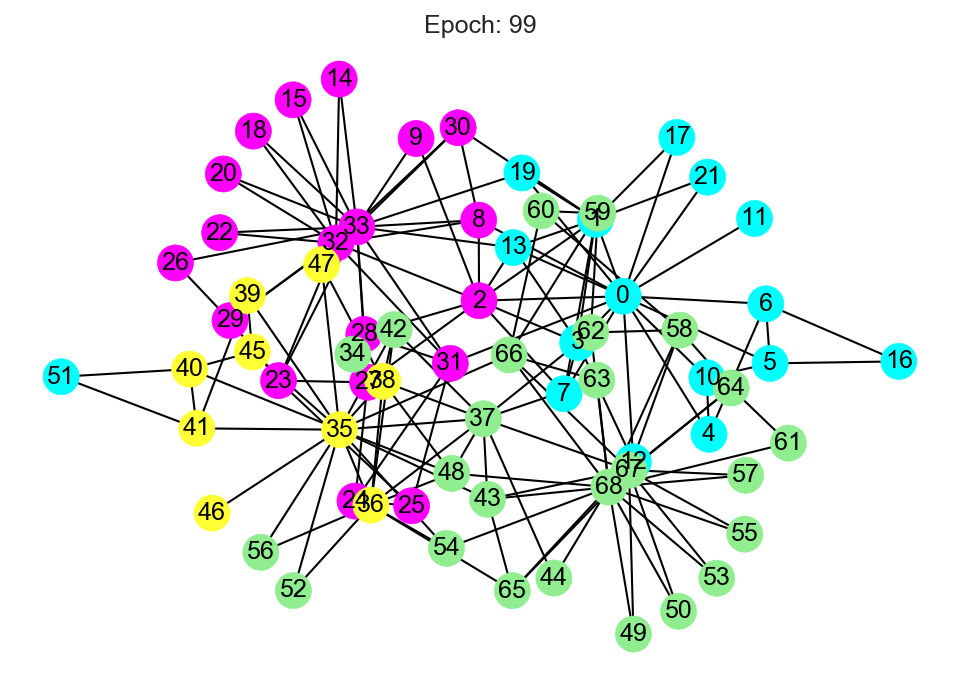

In [61]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    node_colors = ['#00FFFF','#FF00FF','#FFFF33','#90EE90']
    
    pos = {}
    colors = []
    for v in range(G.number_of_nodes()):
        pos[v] = all_logits[i][v].numpy()  # i = no. of epoch, v = no. of node
        cls = pos[v].argmax()
        colors.append(node_colors[cls])
        #colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G, pos1, node_color=colors,with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(99)

## Creating Graph by progressively adding more nodes and edges

In [111]:
G = dgl.DGLGraph()
G.add_nodes(10)

#Adding edges using for loop
for i in range(1,4):
    G.add_edge(i,0)

#Adding edges using python list
src = list(range(4,8))
dst = [0]*4
G.add_edges(src,dst)

#Adding edges using PyTorch tensors
src = torch.tensor([8,9])
dst = torch.tensor([0,0])
G.add_edges(src,dst)

C:\Users\Varun Sirpal\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Varun Sirpal\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


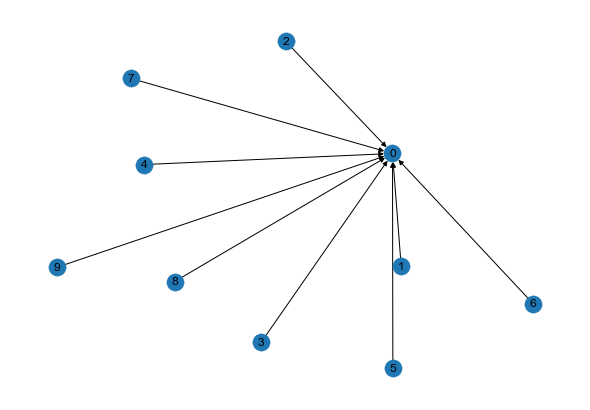

In [82]:
plt.style.use("seaborn")
nx.draw(G.to_networkx(), with_labels=True)
plt.show()